<a href="https://colab.research.google.com/github/BC-Chang/ms-net-workshop/blob/main/U_Net_Segmentation_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to CNNs For Image Segmentation

Now that we have the building blocks for deep learning, we can start building more interesting models!

Recall that convolutional neural networks (CNNs) are a specialized type of neural network designed to handle data with a grid-like topology, such as images.

Unlike traditional neural networks,  CNNs automatically learn localized spatial features directly from the input data, making them ideal for image and 3D data analysis. CNNs use a combination of convolutional layers, pooling layers, and fully connected layers to extract and learn these local features.

For digital rock applications, CNNs have shown success in image segmentation, geometric and transport property prediction, and more.

Here, we will build our first convolutional neural network, called U-Net, to try to create a basic segmentation model. More details on U-Net to come...

In [1]:
#@title Import packages

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim

from tqdm import tqdm

!pip install livelossplot --quiet
from livelossplot import PlotLosses

## Major CNN components

Before we begin building our segmentation model, let's go over the major components of CNNs:

### 1. Convolutional Layers
Convolutional layers are a fundamental building block of Convolutional Neural Networks (CNNs). Convolutional layers focus on learning local patterns by applying a set of filters (also known as kernels) across the input data.


**Filters/Kernels:**

A filter is a small matrix of weights that gets convolved across the input image. Each filter is designed to detect specific features such as edges, textures, or patterns within a local region of the input image.

<img src="https://miro.medium.com/v2/resize:fit:1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" width="500" height="300">

**Feature Maps:**

The output of a convolutional layer is called a feature (or activation) map. It highlights the specific features detected by the filters across the input.
Multiple filters are applied in a single convolutional layer, allowing the layer to detect a variety of features from the input data.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*wju0Urp6KpAT11wktTp5Sg.png" width="750" height="265">

**Stride:**

The stride determines how much the filter moves across the input after each operation. A stride of 1 means the filter moves one pixel/voxel at a time.

A larger stride reduces the spatial dimensions of the output feature map.

<img src="https://miro.medium.com/v2/resize:fit:588/format:webp/1*BMngs93_rm2_BpJFH2mS0Q.gif" width="300" height="265">




### 2. Pooling Layers

Pooling layers are primarily used to reduce the spatial dimensions of the feature maps. This helps decrease the number of parameters that the network has to train, consolidates prominant features, and helps keep the network robust against small translations or distortions.

The most common types of pooling are:
- *Max Pooling:*

  Select the maximum value from each window. This preserves the strongest features while discarding less important information

- *Average Pooling:*

  Compute the average of all values within a window, which smooths out the feature map

  <img src="https://www.researchgate.net/profile/Alla-Eddine-Guissous/publication/337336341/figure/fig15/AS:855841334898691@1581059883782/Example-for-the-max-pooling-and-the-average-pooling-with-a-filter-size-of-22-and-a.jpg" width="700" height="200">


### 3. Activation Functions

Activation functions introduce non-linearity into the model, allowing it to learn complex patterns. Additionally, they allow CNNs to create decision boundaries for tasks such as classification and segmentation.

Two activation functions common to CNNs, and ones that we will work with today, are:

- **ReLU (Rectified Linear Unit)**:

 $f(x) = \text{max}(0, x)$

  <img src="https://sebastianraschka.com/images/faq/relu-derivative/relu_3.png" width="300" height="200">

ReLU is commonly used within the hidden layers of CNNs. They have been shown to perform better in a variety of image analysis tasks than others, such as sigmoid and tanh.

- **Softmax**

 $f(x_i) = \frac{e^{x_i}}{\Sigma e^{x_j}}$

Softmax is commonly used as the activation function of the output layer for multiclass segmentation networks. It effectively converts the raw model output (called logits) to probabilities that sum to 100%.

### 4. Batch Normalization

Batch normalization improves training by normalizing the inputs to each layer. In CNNs, BatchNorm normalizes the activations of each feature map across each batch.

This helps reduce shifts in the distribution of feature maps (called internal covariate shift) between batches and stabilizes training.


**With these major components of CNNs in mind, we can start building our own!**

## U-Net

U-Net is a type of CNN architecture specifically designed for segmentation tasks. This is a simplified U-Net diagram:


  <img src="https://nchlis.github.io/2019_10_30/architecture_unetV2.png" width="550" height="225">


U-Net follows a symmetric encoder-decoder structure. The encoder extracts features of the image and compresses the resulting feature maps into a lower-dimensional representations. In earlier

The decoder reconstructs this representation back to the original image size and generates the final segmentation prediction. It primarily upsamples the feature maps and combines them with the high-resolution feature maps from the corresponding encoder blocks through skip connections to retain spatial information that is often lost during downsampling.

The final output of the decoder passes through a convolutional layer to produce the segmentation map.

Both the encoder and the decoder consists of convolutional blocks, each containing a two convolutional layers, two ReLU activation functions, and two batch normalization steps. Max Pooling is performed on the output of each encoder block.

A more detailed U-Net diagram is shown below:

  <img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*zYrwp34DslR_9wLHMVAITg.png" width="650" height="400">


In the following cell, we define our U-Net Model. Note that we reduced the size of the model for demonstration purposes.


In [2]:
#@title 3D U-Net Model

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        # Max Pooling
        self.Maxpooler = nn.MaxPool3d(kernel_size=2, stride=2)

        # Upsampling
        self.d4 = self.up_conv(512, 256)
        self.d3 = self.up_conv(256, 128)
        self.d2 = self.up_conv(128, 64)
        self.d1 = self.up_conv(64, 32)

        # Encoder
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec4 = self.conv_block(512, 256)
        self.dec3 = self.conv_block(256, 128)
        self.dec2 = self.conv_block(128, 64)
        self.dec1 = self.conv_block(64, 32)

        # Final output
        self.final_conv = nn.Conv3d(32, out_channels, kernel_size=1)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def up_conv(self, in_channels, out_channels):
      return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
      )

    def conv_trans_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)

        x2 = self.Maxpooler(enc1)
        enc2 = self.enc2(x2)

        x3 = self.Maxpooler(enc2)
        enc3 = self.enc3(x3)

        x4 = self.Maxpooler(enc3)
        enc4 = self.enc4(x4)

        # Bottleneck
        x5 = self.Maxpooler(enc4)
        bottleneck = self.bottleneck(x5)

        # Decoder path
        d4 = self.d4(bottleneck)
        dec4 = self.dec4(torch.cat((d4, enc4), dim=1))

        d3 = self.d3(dec4)
        dec3 = self.dec3(torch.cat((d3, enc3), dim=1))

        d2 = self.d2(dec3)
        dec2 = self.dec2(torch.cat((d2, enc2), dim=1))

        d1 = self.d1(dec2)
        dec1 = self.dec1(torch.cat((d1, enc1), dim=1))

        # Final output
        output = self.final_conv(dec1)
        return output

## Data Loading


### Our Training Data

For the purposes of this short course, we pulled data from the [Gildehauser Sandstone](https://www.digitalrocksportal.org/projects/134) project on Digital Rocks Portal.

The dataset consists of synchtron-based micro-CT images of a Gildehauser sandstone, imaged at 4.4$\mu$m resolution. The authors of the project segmented the image already.

As a preprocessing step, we extracted $64^3$ voxel subsets from the overall image so that we could ensure the model and data would fit on Colab GPUs. There are a total of 50 subsets available to download; but for sake of time, we will only train with 10.

These subsets are hosted in a [public Github Repository](https://github.com/digital-porous-media/ML_segmentation_workshop) for ease of access.

**Run the following cell to download the data.**

In [3]:
!apt-get -q install unzip
!rm -rf gray
!rm -rf segmented

!curl -o gray.zip "https://raw.githubusercontent.com/digital-porous-media/ML_segmentation_workshop/main/gray_50.zip"
!curl -o segmented.zip "https://raw.githubusercontent.com/digital-porous-media/ML_segmentation_workshop/main/segmented_50.zip"

!unzip -q gray.zip
!unzip -q segmented.zip

!mv gray_50/ gray/
!mv segmented_50/ segmented/

!rm -rf gray.zip segmented.zip

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.5M  100 20.5M    0     0  18.4M      0  0:00:01  0:00:01 --:--:-- 18.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  592k  100  592k    0     0  1582k      0 --:--:-- --:--:-- --:--:-- 1585k


(-0.5, 63.5, 63.5, -0.5)

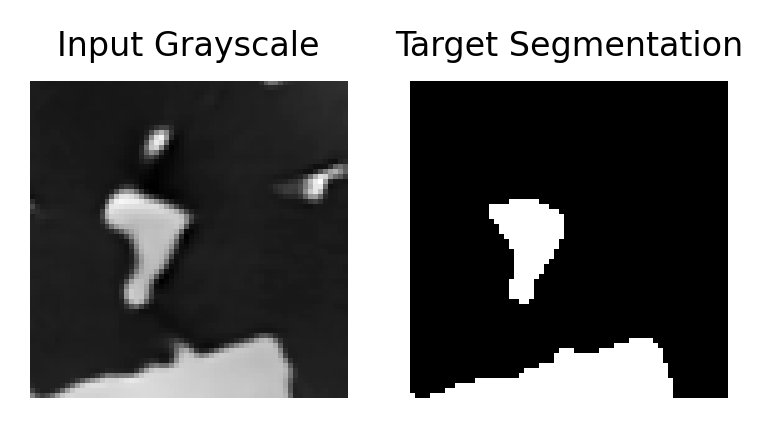

In [4]:
# Inspect our training samples
sample_num = 0
gray_img = np.load(f"/content/gray/134_{sample_num}.npy")
seg_img = np.load(f"/content/segmented/134_{sample_num}.npy")


plt.figure(dpi=300, figsize=(3,1.5))
plt.subplot(1, 2, 1)
plt.imshow(gray_img[43], cmap="gray_r")
plt.title('Input Grayscale', fontsize=8)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(seg_img[43], cmap="gray_r")
plt.title('Target Segmentation', fontsize=8)
plt.axis('off')

### PyTorch Datasets and DataLoaders
PyTorch has provided standard Dataset and DataLoader objects to efficiently handle data processing during training.

The Dataset object allows us to customize how data is read in and preprocessed. Here we define a NumpyDataset object that can read in our .npy images. PyTorch also has built in functions to split training, validation, and test data once they are in Dataset objects.

The DataLoader object handles the management of training data during training. They take care of sending mini-batches, parallel data loading, and data transformations on the fly.

In [5]:
#@title Define a Dataset Object

# We first create a custom torch Dataset that allows us to read the Numpy files
class NumpyDataset(Dataset):
  def __init__(self, image_ids, data_dir_grayscale, data_dir_segmented):
    self.image_ids = image_ids
    self.data_dir_grayscale = data_dir_grayscale
    self.data_dir_segmented = data_dir_segmented

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    try:
      # Load data from .npy files
      grayscale = np.load(f"{self.data_dir_grayscale}/134_{self.image_ids[idx]}.npy")
      segmented = np.load(f"{self.data_dir_segmented}/134_{self.image_ids[idx]}.npy")

      grayscale = grayscale[None, :, :, :]
      # segmented = segmented[None, :, :, :]
    except FileNotFoundError as e:
      print(f"File not found: {e}")
      raise

    # Convert numpy arrays to PyTorch tensors
    image = torch.tensor(grayscale, dtype=torch.float32) / 65535.0
    label = torch.tensor(segmented, dtype=torch.long)

    return image, label


In [6]:
#@title Create training, validation, and test datasets
SEED = 15706283

# Full dataset
n_samples = 10
full_data = NumpyDataset(image_ids=np.arange(n_samples),
                         data_dir_grayscale="/content/gray",
                         data_dir_segmented="/content/segmented")

# We split the dataset into 60, 20, 20 split for training, validation, and testing
# We set a seed for reproducibility.
generator = torch.Generator().manual_seed(SEED)
train_set, val_set, test_set = random_split(full_data, [0.6, 0.2, 0.2], generator=generator)

print(f"{train_set.indices = }")
print(f"{val_set.indices = }")
print(f"{test_set.indices = }")

train_set.indices = [1, 3, 0, 7, 8, 2]
val_set.indices = [4, 9]
test_set.indices = [5, 6]


In [7]:
#@title Create DataLoader objects for training and evaluation
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

## Model Training

Before we set up our training loop, it's important to define how we want our model trained.

For the purposes of this demonstration, we will preset the number of training epochs to 100, and the learning rate to 1e-4. These can be adjusted.

**Model Instantiation**

Next, we instantiate our model ```UNet3D()``` model. Note that we set ```in_channels=1``` because our input is a grayscale image. If we had an RGB image, we would set ```in_channels=3```.

The number of output channels correspond to the number of output labels we expect in the image. For a binary image, we set ```out_channels=2```. We could increase the number of output channels if we wanted to do multi-mineral segmentation.

**Optimizer**
Here, we choose to use the AdamW optimizer, a new variant of the Adam optimizer. The actual implementation details of these are not important here.Just keep in mind that optimizers apply specific algorithms to update the model parameters so that training can converge more quickly and stably.

**Loss Function**
The Cross Entropy Loss is widely used for multi-class and binary classification problems. The formula is given by:

$$L = -\frac{1}{N}\sum^N_{i=1}\sum^C_{c=1} y_{i,c} \text{log}(p_{i,c}),$$

where:
- $y_{i,c}$ is 1 if the $i$-th sample belongs to class $c$, and 0 otherwise.
- $p_{i,c}$ is the probability of class c for the $i$-th sample
- C is the total number of classes
- N is the total number of samples.


In [8]:
#@title Define some training parameters

LR = 1e-4
epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

model = UNet3D(in_channels=1, out_channels=2).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR)
loss_f = nn.CrossEntropyLoss()

Running on cuda


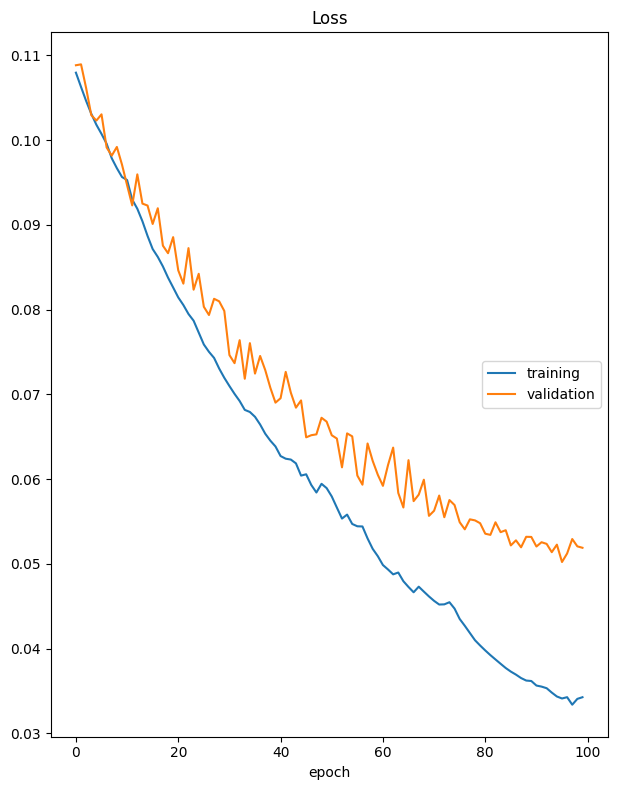

Loss
	training         	 (min:    0.033, max:    0.108, cur:    0.034)
	validation       	 (min:    0.050, max:    0.109, cur:    0.052)


In [10]:
#@title Training Loop
train_loss = []
val_loss = []

liveloss = PlotLosses()

for epoch in tqdm(range(epochs)):
  logs = {}
  # Iterate through training samples
  model.train()
  train_loss_epoch = 0
  for idx, sample in enumerate(train_loader):
    x, y = [s.to(device) for s in sample]
    y_pred = model(x)

    optimizer.zero_grad()
    loss = loss_f(y_pred, y.long())

    loss.backward()
    optimizer.step()

    train_loss_epoch += loss.item()
  logs["loss"] = train_loss_epoch / (idx + 1)
  train_loss.append(train_loss_epoch / (idx + 1))

  # Validation
  model.eval()
  val_loss_epoch = 0
  with torch.no_grad():
    for idx, sample in enumerate(val_loader):
      x, y = [s.to(device) for s in sample]
      y_pred = model(x)

      loss = loss_f(y_pred, y)
      val_loss_epoch += loss.item()
    logs["val_loss"] = val_loss_epoch / (idx + 1)
    val_loss.append(val_loss_epoch / (idx + 1))
  liveloss.update(logs)
  liveloss.send()

  # print("-"*30)
  # print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
  # print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")

## Model Evaluation

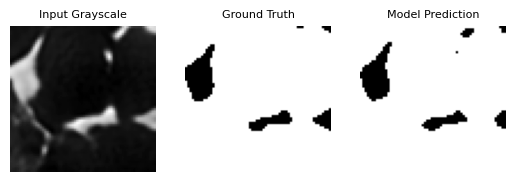

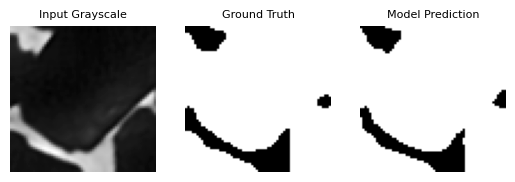

In [11]:
#@title Test the model
model.eval()
with torch.no_grad():
  for idx, sample in enumerate(test_loader):
    x, y = [s.to(device) for s in sample]
    y_pred = model(x)
    loss = loss_f(y_pred, y)

    probabilities = F.softmax(y_pred, dim=1)

    # Get the predicted class by taking the argmax along the channel dimension
    predicted_classes = torch.argmax(probabilities, dim=1)

    # Convert to binary image
    pred_bin = (predicted_classes == 1).int()  # Assuming class 1 is the foreground

    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x.cpu()[0, 0, 0, :, :], cmap='gray_r')
    plt.axis('off')
    plt.title('Input Grayscale', fontsize=8)

    plt.subplot(1,3,2)
    plt.imshow(y.cpu()[0, 0, :, :], cmap='binary_r')
    plt.axis('off')
    plt.title('Ground Truth', fontsize=8)

    plt.subplot(1,3,3)
    plt.imshow(pred_bin.cpu()[0, 0, :, :], cmap='binary_r')
    plt.axis('off')
    plt.title('Model Prediction', fontsize=8)